In [1]:
# Cell A: Install Dependencies
!pip install -q torchxrayvision albumentations scikit-learn
print("Dependencies installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 59.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00:00:0100:01
Dependencies in

In [2]:
# Cell B: Load Your Champion Model and Artifacts

import torch
import torch.nn as nn
import torchxrayvision as xrv
import os
import json

# --- 1. Configuration ---
# This path MUST point to the dataset you just created and added.
# Replace 'my-champion-chexnet-model-v1' with the actual folder name.
MODEL_INPUT_DIR = '/kaggle/input/latest5ab/'
CHECKPOINT_FILENAME = 'best_model_all_out_v1.pth' # Or your exact .pth filename
THRESHOLDS_FILENAME = 'optimal_thresholds_all_out_v1.json' # Or your exact .json filename

CHECKPOINT_PATH = os.path.join(MODEL_INPUT_DIR, CHECKPOINT_FILENAME)
THRESHOLDS_PATH = os.path.join(MODEL_INPUT_DIR, THRESHOLDS_FILENAME)

# Define the 14 disease labels your model was trained on
disease_labels = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 
    'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 
    'Fibrosis', 'Pleural_Thickening', 'Hernia'
]
num_classes = len(disease_labels)

# --- 2. Define the Model Architecture (MUST MATCH the saved model) ---
class MyChampionModel(nn.Module):
    def __init__(self, num_classes):
        super(MyChampionModel, self).__init__()
        # Use the same architecture and pretrained base
        self.backbone = xrv.models.DenseNet(weights="densenet121-res224-all")
        self.backbone.op_threshs = None
        
        num_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        
        # Use the same deeper head architecture
        self.head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6), # Ensure this matches the trained model's dropout
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

# --- 3. Load the Model ---
print("--- Loading Your Champion Model ---")
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model architecture
my_model = MyChampionModel(num_classes=num_classes)

# Load the saved weights
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
    my_model.load_state_dict(checkpoint['model_state_dict'])
    my_model.to(device)
    my_model.eval() # Set to evaluation mode
    print(f"✅ Your champion model loaded successfully from epoch {checkpoint.get('epoch', 'N/A')}.")
else:
    print(f"❌ ERROR: Champion model checkpoint not found at '{CHECKPOINT_PATH}'")
    my_model = None

# --- 4. Load the Optimal Thresholds ---
print("\n--- Loading Optimal Thresholds ---")
if os.path.exists(THRESHOLDS_PATH):
    with open(THRESHOLDS_PATH, 'r') as f:
        my_model_thresholds = json.load(f)
    print("✅ Your model's optimal thresholds loaded successfully.")
    # print(my_model_thresholds) # Uncomment to view
else:
    print(f"❌ ERROR: Thresholds file not found at '{THRESHOLDS_PATH}'")
    my_model_thresholds = None

--- Loading Your Champion Model ---
Using device: cuda
If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
✅ Your champion model loaded successfully from epoch 25.

--- Loading Optimal Thresholds ---
✅ Your model's optimal thresholds loaded successfully.


In [3]:
# Cell C: Load Arnoweng Model (Targeted Execution)

import torch
import torch.nn as nn
import torchvision # The model.py file needs this
import sys
import os
from collections import OrderedDict
import ast # Abstract Syntax Tree library to find the class definition

# --- 1. Manually extract ONLY the DenseNet121 class definition from the file ---
SOURCE_REPO_PATH = "/kaggle/input/arnoweng-chexnet/CheXNet-master"
model_py_path = os.path.join(SOURCE_REPO_PATH, "model.py")
print(f"--- Parsing class definition from: {model_py_path} ---")

ArnowengDenseNet121 = None
try:
    with open(model_py_path, 'r') as f:
        source_code = f.read()

    # Parse the code into an Abstract Syntax Tree
    tree = ast.parse(source_code)
    
    # Find the class definition node for DenseNet121
    class_node = None
    for node in ast.walk(tree):
        if isinstance(node, ast.ClassDef) and node.name == 'DenseNet121':
            class_node = node
            break
            
    if class_node is None:
        raise RuntimeError("Could not find 'class DenseNet121' in model.py")
        
    # Reconstruct the source code for ONLY this class
    # The unparse function was added in Python 3.9
    try:
        class_source = ast.unparse(class_node)
    except AttributeError: # Fallback for older ast versions without unparse
        import astor
        class_source = astor.to_source(class_node)
        
    # Execute just the class definition. This avoids running the main() function.
    exec(class_source, globals())
    ArnowengDenseNet121 = DenseNet121
    
    print("✅ Successfully defined 'DenseNet121' class by targeted execution.")

except Exception as e:
    print(f"❌ ERROR: Failed to parse or execute the class definition from model.py. Error: {e}")

# --- 2. Instantiate Model and Load Checkpoint ---
if ArnowengDenseNet121:
    WEIGHTS_PATH = os.path.join(SOURCE_REPO_PATH, "model.pth.tar")
    arnoweng_class_names = [
        'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 
        'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 
        'Fibrosis', 'Pleural_Thickening', 'Hernia'
    ]
    NUM_ARNOWENG_CLASSES = len(arnoweng_class_names)
    device_arnoweng = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print("\n--- Loading Arnoweng's Pre-trained CheXNet Model ---")
    
    arnoweng_model = ArnowengDenseNet121(out_size=NUM_ARNOWENG_CLASSES)
    
    print(f"Loading checkpoint from: {WEIGHTS_PATH}")
    checkpoint = torch.load(WEIGHTS_PATH, map_location=device_arnoweng)
    state_dict_from_file = checkpoint['state_dict']
    
    # Use the complex key re-mapping logic
    final_state_dict = OrderedDict()
    for key, value in state_dict_from_file.items():
        new_key = key.replace("module.", "", 1).replace(".norm.1.", ".norm1.").replace(".norm.2.", ".norm2.").replace(".conv.1.", ".conv1.").replace(".conv.2.", ".conv2.")
        if not new_key.startswith('densenet121.'):
             if 'classifier' in new_key or 'features' in new_key:
                 new_key = 'densenet121.' + new_key
        final_state_dict[new_key] = value
        
    try:
        arnoweng_model.load_state_dict(final_state_dict, strict=False)
        print("✅ Arnoweng model weights loaded successfully.")
    except RuntimeError as e:
        print(f"   ❌ FATAL ERROR: Could not load weights after re-mapping. Error: {e}")
        arnoweng_model = None

    if arnoweng_model:
        arnoweng_model.to(device_arnoweng)
        arnoweng_model.eval()
        print(f"✅ Arnoweng model is on device '{device_arnoweng}' and in evaluation mode.")
else:
    print("❌ ERROR: Could not proceed with loading the Arnoweng model.")
    arnoweng_model = None

--- Parsing class definition from: /kaggle/input/arnoweng-chexnet/CheXNet-master/model.py ---
✅ Successfully defined 'DenseNet121' class by targeted execution.

--- Loading Arnoweng's Pre-trained CheXNet Model ---


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 169MB/s]


Loading checkpoint from: /kaggle/input/arnoweng-chexnet/CheXNet-master/model.pth.tar
✅ Arnoweng model weights loaded successfully.
✅ Arnoweng model is on device 'cuda' and in evaluation mode.


In [4]:
# Cell D: Define Data Pipelines and Dataset Classes

import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from PIL import Image

print("--- Defining Data Pipelines ---")

# --- Pipeline for YOUR Model (Albumentations) ---
IMG_SIZE = 224
val_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    A.ToFloat(max_value=255.0),
    ToTensorV2()
])
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, disease_labels_list, transform=None):
        self.df = dataframe
        self.transform = transform
        self.image_paths = self.df['full_path'].values
        self.labels = self.df[disease_labels_list].values.astype(np.float32)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        try:
            image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
            if image is None: raise IOError("cv2.imread failed")
            if self.transform:
                image = self.transform(image=image)['image']
            if image.ndim == 2: image = image.unsqueeze(0)
            return image, torch.tensor(self.labels[idx], dtype=torch.float32)
        except Exception as e:
            return None, None
print("✅ Pipeline for your model ('val_transform' and 'ChestXrayDataset') defined.")

# --- Pipeline for Arnoweng Model (torchvision) ---
arnoweng_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
class ArnowengDataset(Dataset):
    def __init__(self, dataframe, disease_labels_list, transform=None):
        self.df = dataframe
        self.transform = transform
        self.image_paths = self.df['full_path'].values
        self.labels = self.df[disease_labels_list].values.astype(np.float32)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(self.labels[idx], dtype=torch.float32)
        except Exception as e:
            return None, None
print("✅ Pipeline for Arnoweng model ('arnoweng_transform' and 'ArnowengDataset') defined.")

--- Defining Data Pipelines ---
✅ Pipeline for your model ('val_transform' and 'ChestXrayDataset') defined.
✅ Pipeline for Arnoweng model ('arnoweng_transform' and 'ArnowengDataset') defined.


In [5]:
# Cell E: Prepare and Split the Data

import pandas as pd
import os
from glob import glob
from sklearn.model_selection import GroupShuffleSplit

print("--- [Data Preparation Step] ---")

# --- 1. Configuration ---
# This should be the path to your main NIH dataset
DATA_DIR = "/kaggle/input/data/"
METADATA_CSV_PATH = os.path.join(DATA_DIR, "Data_Entry_2017.csv")
# The list of 14 diseases both models can predict
DISEASE_LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 
    'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 
    'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

# --- 2. Find all image paths ---
print("Scanning for all image files...")
# Use the correct glob pattern for your dataset structure
glob_pattern = os.path.join(DATA_DIR, 'images_*', 'images', '*.png')
all_image_paths_map = {os.path.basename(p): p for p in glob(glob_pattern)}
print(f"Found {len(all_image_paths_map)} image paths.")

# --- 3. Load metadata and create 'full_path' column ---
print("Loading and processing metadata CSV...")
df = pd.read_csv(METADATA_CSV_PATH)
df['full_path'] = df['Image Index'].map(all_image_paths_map)
# Remove rows that have a CSV entry but no matching image file
df.dropna(subset=['full_path'], inplace=True)
print(f"DataFrame created with {len(df)} images with valid paths.")

# --- 4. One-hot encode the labels ---
print("Creating one-hot encoded labels for all 14 diseases...")
for label in DISEASE_LABELS:
    df[label] = df['Finding Labels'].apply(lambda finding_str: 1 if label in finding_str else 0)
    
# --- 5. Perform Patient-Level Split ---
print("\nPerforming patient-level split (80/20) to create train_df and val_df...")
VAL_SIZE = 0.2
RANDOM_STATE = 42 # Use a fixed state for reproducible splits
groups = df['Patient ID']
gss = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE)
train_idx, val_idx = next(gss.split(df, groups=groups))

train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx] # This is the DataFrame we need for the next cell

print(f"Training set: {len(train_df)} images from {train_df['Patient ID'].nunique()} unique patients.")
print(f"Validation set: {len(val_df)} images from {val_df['Patient ID'].nunique()} unique patients.")
print("✅ 'train_df' and 'val_df' are now ready.")

--- [Data Preparation Step] ---
Scanning for all image files...
Found 112120 image paths.
Loading and processing metadata CSV...
DataFrame created with 112120 images with valid paths.
Creating one-hot encoded labels for all 14 diseases...

Performing patient-level split (80/20) to create train_df and val_df...
Training set: 89826 images from 24644 unique patients.
Validation set: 22294 images from 6161 unique patients.
✅ 'train_df' and 'val_df' are now ready.


In [6]:
# Cell F: Create DataLoaders for Both Models

from torch.utils.data import DataLoader

# --- Prerequisite Checks ---
# This cell assumes the following are defined in previous cells:
# - 'val_df': The validation DataFrame (from Cell E)
# - 'disease_labels': The list of 14 class names (from Cell B)
# - 'ChestXrayDataset': The Dataset class for your model (from Cell D)
# - 'ArnowengDataset': The Dataset class for the Arnoweng model (from Cell D)
# - 'val_transform': The Albumentations transform for your model (from Cell D)
# - 'arnoweng_transform': The torchvision transform for the Arnoweng model (from Cell D)

if 'val_df' not in locals() or 'ChestXrayDataset' not in globals() or 'ArnowengDataset' not in globals():
    print("❌ ERROR: Prerequisites not met. Please run previous cells (especially D and E).")
else:
    print("--- Creating DataLoaders for Ensembling Evaluation ---")
    
    BATCH_SIZE = 32 # Set a consistent batch size for evaluation
    
    # --- 1. DataLoader for YOUR Champion Model ---
    my_model_val_dataset = ChestXrayDataset(
        dataframe=val_df,
        disease_labels_list=disease_labels, # Pass the labels explicitly
        transform=val_transform
    )
    my_model_val_loader = DataLoader(
        my_model_val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0 # Use 0 for stable evaluation
    )
    print(f"✅ Created 'my_model_val_loader' with {len(my_model_val_dataset)} images.")

    # --- 2. DataLoader for the Arnoweng Model ---
    arnoweng_val_dataset = ArnowengDataset(
        dataframe=val_df,
        disease_labels_list=disease_labels, # Pass the labels explicitly
        transform=arnoweng_transform
    )
    arnoweng_val_loader = DataLoader(
        arnoweng_val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0 # Use 0 for stable evaluation
    )
    print(f"✅ Created 'arnoweng_val_loader' with {len(arnoweng_val_dataset)} images.")

--- Creating DataLoaders for Ensembling Evaluation ---
✅ Created 'my_model_val_loader' with 22294 images.
✅ Created 'arnoweng_val_loader' with 22294 images.


In [7]:
# Cell G: Get Predictions from Arnoweng Model

import torch
from tqdm import tqdm
import numpy as np

# --- Prerequisite check ---
if 'arnoweng_model' not in locals() or 'arnoweng_val_loader' not in locals():
    print("❌ ERROR: 'arnoweng_model' or 'arnoweng_val_loader' is not ready. Please run Cell C and Cell F.")
else:
    print("--- Getting predictions from the Arnoweng model on the validation set ---")
    
    # Initialize lists to store results
    arnoweng_all_pred_probs_list = []
    all_true_labels_list = []
    
    # Ensure model is in eval mode and on the correct device
    arnoweng_model.eval()
    device = device_arnoweng # Use the device defined when loading the model
    
    progress_bar = tqdm(arnoweng_val_loader, desc="Arnoweng Model Predicting", leave=False)
    
    with torch.no_grad():
        for batch_data in progress_bar:
            if batch_data is None or batch_data[0] is None: continue # Safety check
                
            images, labels = batch_data
            images = images.to(device, non_blocking=True)
            
            # The Arnoweng model's forward pass gives probabilities directly (it has a Sigmoid layer)
            outputs = arnoweng_model(images)
            
            # Append results to our lists (move to CPU)
            arnoweng_all_pred_probs_list.append(outputs.cpu())
            all_true_labels_list.append(labels) # Labels are already on CPU from the dataloader
            
    progress_bar.close()
    
    # Concatenate all batch results into single large NumPy arrays
    if arnoweng_all_pred_probs_list and all_true_labels_list:
        arnoweng_pred_probs = torch.cat(arnoweng_all_pred_probs_list, dim=0).numpy()
        # The true labels will be used for all subsequent evaluations
        val_true_labels = torch.cat(all_true_labels_list, dim=0).numpy()
        
        print(f"✅ Successfully collected predictions from the Arnoweng model.")
        print(f"   Predictions shape: {arnoweng_pred_probs.shape}")
        print(f"   True labels shape: {val_true_labels.shape}")
    else:
        print("❌ ERROR: No predictions were collected.")
        # Define empty arrays to prevent errors in later cells
        arnoweng_pred_probs = np.array([])
        val_true_labels = np.array([])

--- Getting predictions from the Arnoweng model on the validation set ---


✅ Successfully collected predictions from the Arnoweng model.
   Predictions shape: (22294, 14)
   True labels shape: (22294, 14)


In [8]:
# Cell H: Get Predictions from Your Champion Model

import torch
from tqdm import tqdm
import numpy as np

# --- Prerequisite check ---
if 'my_model' not in locals() or 'my_model_val_loader' not in locals():
    print("❌ ERROR: 'my_model' or 'my_model_val_loader' is not ready. Please run previous cells.")
# We also check if the true labels from the previous step exist
elif 'val_true_labels' not in locals():
    print("❌ ERROR: 'val_true_labels' not collected. Please run Cell G first.")
else:
    print("--- Getting predictions from YOUR champion model on the validation set ---")
    
    # Initialize a list to store your model's predictions
    my_model_all_pred_probs_list = []
    
    # Ensure your model is in eval mode and on the correct device
    my_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Re-affirm device for clarity
    my_model.to(device)
    
    progress_bar = tqdm(my_model_val_loader, desc="Your Model Predicting", leave=False)
    
    with torch.no_grad():
        for batch_data in progress_bar:
            if batch_data is None or batch_data[0] is None: continue
                
            images, labels = batch_data
            images = images.to(device, non_blocking=True)
            
            # Your model outputs logits, so we need to apply sigmoid
            outputs = my_model(images)
            probabilities = torch.sigmoid(outputs)
            
            # Append results to our list (move to CPU)
            my_model_all_pred_probs_list.append(probabilities.cpu())
            
    progress_bar.close()
    
    # Concatenate all batch results into a single large NumPy array
    if my_model_all_pred_probs_list:
        my_model_pred_probs = torch.cat(my_model_all_pred_probs_list, dim=0).numpy()
        
        print(f"✅ Successfully collected predictions from your champion model.")
        print(f"   Predictions shape: {my_model_pred_probs.shape}")
        
        # Sanity check to ensure prediction counts match
        if len(my_model_pred_probs) != len(val_true_labels):
             print(f"   ❌ WARNING: Prediction count ({len(my_model_pred_probs)}) does not match true label count ({len(val_true_labels)}).")
        
    else:
        print("❌ ERROR: No predictions were collected from your model.")
        my_model_pred_probs = np.array([])

--- Getting predictions from YOUR champion model on the validation set ---


Your Model Predicting:   0%|          | 1/697 [00:00<09:26,  1.23it/s]

✅ Successfully collected predictions from your champion model.
   Predictions shape: (22294, 14)


In [10]:
# Cell I: The Complete Model Bake-Off (Final Evaluation)

import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from tqdm import tqdm
import pandas as pd

# --- Prerequisite Checks ---
if 'val_true_labels' not in locals() or \
   'my_model_pred_probs' not in locals() or \
   'arnoweng_pred_probs' not in locals() or \
   'disease_labels' not in locals():
    print("❌ ERROR: One or more prediction arrays or labels are missing. Please run previous cells.")
else:
    # --- A helper function to run the full analysis (to avoid repeating code) ---
    def generate_full_report(model_name, y_true, y_pred_probs, class_names):
        print("\n" + "="*80)
        print(f"               FULL PERFORMANCE REPORT FOR: {model_name}")
        print("="*80)

        # --- 1. Calculate and Compare Macro AUC ---
        print("\n--- AUC SCORES ---")
        try:
            macro_auc = roc_auc_score(y_true, y_pred_probs, average='macro')
            print(f"  - Macro-Averaged AUC: {macro_auc:.4f}")
            # Calculate and print per-class AUCs
            per_class_auc_scores = roc_auc_score(y_true, y_pred_probs, average=None)
            for i, label in enumerate(class_names):
                print(f"    - {label:<20}: {per_class_auc_scores[i]:.4f}")
        except Exception as e:
            print(f"  Could not compute AUC scores. Error: {e}")

        # --- 2. Find Optimal Thresholds ---
        print("\n--- Finding Optimal Thresholds (Maximizing F1-Score) ---")
        optimal_thresholds = {}
        for i, disease_name in enumerate(class_names):
            best_f1 = 0
            best_thresh = 0.5
            for threshold in np.arange(0.01, 0.99, 0.01):
                pred_binary = (y_pred_probs[:, i] >= threshold).astype(int)
                current_f1 = f1_score(y_true[:, i], pred_binary, zero_division=0)
                if current_f1 > best_f1:
                    best_f1 = current_f1
                    best_thresh = threshold
            optimal_thresholds[disease_name] = best_thresh
        print("  ✅ Optimal thresholds found.")

        # --- 3. Generate Final Classification Report ---
        print("\n--- Classification Report (using optimal thresholds) ---")
        final_pred_binary = np.zeros_like(y_pred_probs)
        for i, disease_name in enumerate(class_names):
            final_pred_binary[:, i] = (y_pred_probs[:, i] >= optimal_thresholds[disease_name]).astype(int)
        
        report = classification_report(
            y_true,
            final_pred_binary,
            target_names=class_names,
            zero_division=0
        )
        print(report)
        return optimal_thresholds

    # --- Run the analysis for EACH model ---
    
    # 1. YOUR CHAMPION MODEL
    my_model_optimal_thresholds = generate_full_report(
        "Your Champion Model", 
        val_true_labels, 
        my_model_pred_probs, 
        disease_labels
    )
    
    # 2. ARNOWENG'S MODEL
    arnoweng_optimal_thresholds = generate_full_report(
        "Arnoweng's CheXNet Model", 
        val_true_labels, 
        arnoweng_pred_probs, 
        disease_labels
    )
    
    # 3. ENSEMBLE MODEL
    ensemble_pred_probs = (my_model_pred_probs + arnoweng_pred_probs) / 2.0
    ensemble_optimal_thresholds = generate_full_report(
        "Ensemble Model (Averaged)", 
        val_true_labels, 
        ensemble_pred_probs, 
        disease_labels
    )
    
    print("\n" + "="*80)
    print("                      BAKE-OFF COMPLETE")
    print("="*80)


               FULL PERFORMANCE REPORT FOR: Your Champion Model

--- AUC SCORES ---
  - Macro-Averaged AUC: 0.8481
    - Atelectasis         : 0.8098
    - Cardiomegaly        : 0.9341
    - Effusion            : 0.8894
    - Infiltration        : 0.7124
    - Mass                : 0.8634
    - Nodule              : 0.7605
    - Pneumonia           : 0.7754
    - Pneumothorax        : 0.8827
    - Consolidation       : 0.8294
    - Edema               : 0.9026
    - Emphysema           : 0.9150
    - Fibrosis            : 0.8263
    - Pleural_Thickening  : 0.8183
    - Hernia              : 0.9547

--- Finding Optimal Thresholds (Maximizing F1-Score) ---
  ✅ Optimal thresholds found.

--- Classification Report (using optimal thresholds) ---
                    precision    recall  f1-score   support

       Atelectasis       0.30      0.55      0.39      2207
      Cardiomegaly       0.41      0.48      0.44       618
          Effusion       0.49      0.60      0.54      2553
      I

✅ Ensemble inference function 'predict_with_ensemble' defined.

--- Testing ENSEMBLE inference on 5 NEW random validation images ---

Processing image: 00001772_009.png
True Findings:    Pneumothorax
ENSEMBLE Predicted: Pneumothorax
-------------------------------------------------------------
Detailed Ensemble Probabilities & Predictions:
  - Atelectasis         : Probability=0.1206, Threshold=0.54 
  - Cardiomegaly        : Probability=0.0041, Threshold=0.61 
  - Effusion            : Probability=0.1068, Threshold=0.54 
  - Infiltration        : Probability=0.2266, Threshold=0.46 
  - Mass                : Probability=0.2325, Threshold=0.60 
  - Nodule              : Probability=0.3167, Threshold=0.54 
  - Pneumonia           : Probability=0.0834, Threshold=0.52 
  - Pneumothorax        : Probability=0.6699, Threshold=0.59 >> POSITIVE <<
  - Consolidation       : Probability=0.1817, Threshold=0.54 
  - Edema               : Probability=0.0206, Threshold=0.60 
  - Emphysema           

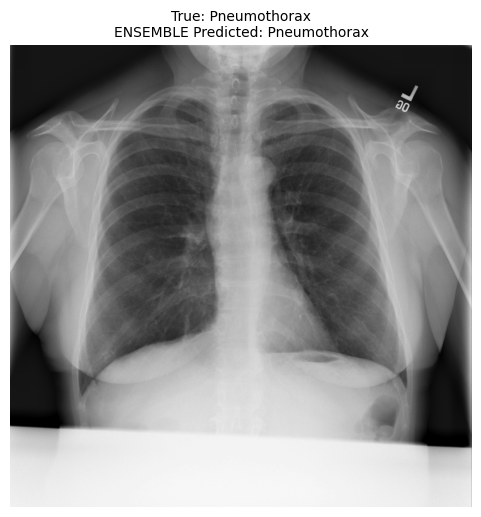


Processing image: 00006150_000.png
True Findings:    No Finding
ENSEMBLE Predicted: No Finding
-------------------------------------------------------------
Detailed Ensemble Probabilities & Predictions:
  - Atelectasis         : Probability=0.1186, Threshold=0.54 
  - Cardiomegaly        : Probability=0.0662, Threshold=0.61 
  - Effusion            : Probability=0.0848, Threshold=0.54 
  - Infiltration        : Probability=0.1667, Threshold=0.46 
  - Mass                : Probability=0.0615, Threshold=0.60 
  - Nodule              : Probability=0.1016, Threshold=0.54 
  - Pneumonia           : Probability=0.0765, Threshold=0.52 
  - Pneumothorax        : Probability=0.1771, Threshold=0.59 
  - Consolidation       : Probability=0.1133, Threshold=0.54 
  - Edema               : Probability=0.0599, Threshold=0.60 
  - Emphysema           : Probability=0.0447, Threshold=0.61 
  - Fibrosis            : Probability=0.0438, Threshold=0.57 
  - Pleural_Thickening  : Probability=0.0499, Thres

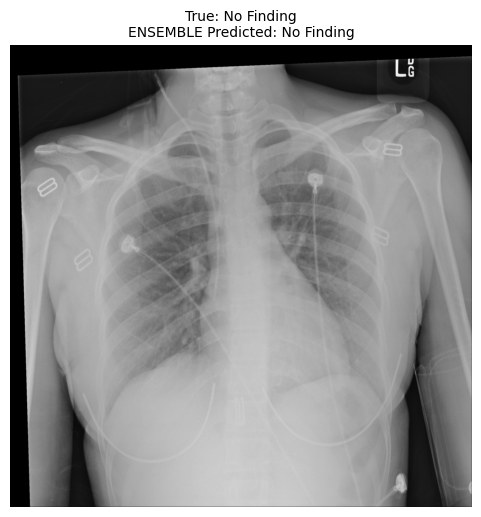


Processing image: 00027585_000.png
True Findings:    Cardiomegaly
ENSEMBLE Predicted: Cardiomegaly, Infiltration
-------------------------------------------------------------
Detailed Ensemble Probabilities & Predictions:
  - Atelectasis         : Probability=0.2593, Threshold=0.54 
  - Cardiomegaly        : Probability=0.6772, Threshold=0.61 >> POSITIVE <<
  - Effusion            : Probability=0.3795, Threshold=0.54 
  - Infiltration        : Probability=0.4684, Threshold=0.46 >> POSITIVE <<
  - Mass                : Probability=0.1444, Threshold=0.60 
  - Nodule              : Probability=0.4405, Threshold=0.54 
  - Pneumonia           : Probability=0.2315, Threshold=0.52 
  - Pneumothorax        : Probability=0.0982, Threshold=0.59 
  - Consolidation       : Probability=0.1726, Threshold=0.54 
  - Edema               : Probability=0.0739, Threshold=0.60 
  - Emphysema           : Probability=0.1776, Threshold=0.61 
  - Fibrosis            : Probability=0.3529, Threshold=0.57 
  - P

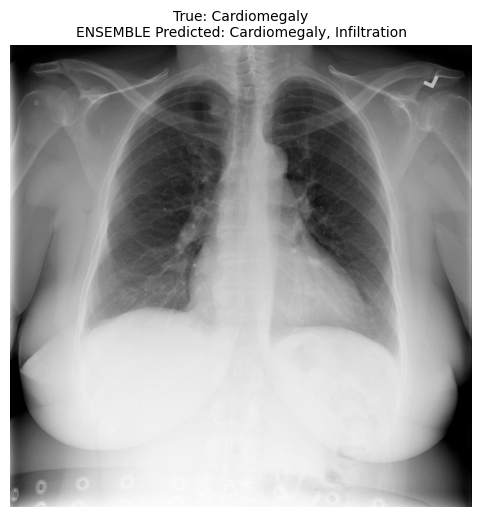


Processing image: 00028876_002.png
True Findings:    No Finding
ENSEMBLE Predicted: Mass, Pneumothorax, Emphysema
-------------------------------------------------------------
Detailed Ensemble Probabilities & Predictions:
  - Atelectasis         : Probability=0.4172, Threshold=0.54 
  - Cardiomegaly        : Probability=0.0587, Threshold=0.61 
  - Effusion            : Probability=0.2807, Threshold=0.54 
  - Infiltration        : Probability=0.2624, Threshold=0.46 
  - Mass                : Probability=0.6079, Threshold=0.60 >> POSITIVE <<
  - Nodule              : Probability=0.4914, Threshold=0.54 
  - Pneumonia           : Probability=0.0857, Threshold=0.52 
  - Pneumothorax        : Probability=0.7307, Threshold=0.59 >> POSITIVE <<
  - Consolidation       : Probability=0.2214, Threshold=0.54 
  - Edema               : Probability=0.0376, Threshold=0.60 
  - Emphysema           : Probability=0.6449, Threshold=0.61 >> POSITIVE <<
  - Fibrosis            : Probability=0.1021, Thresh

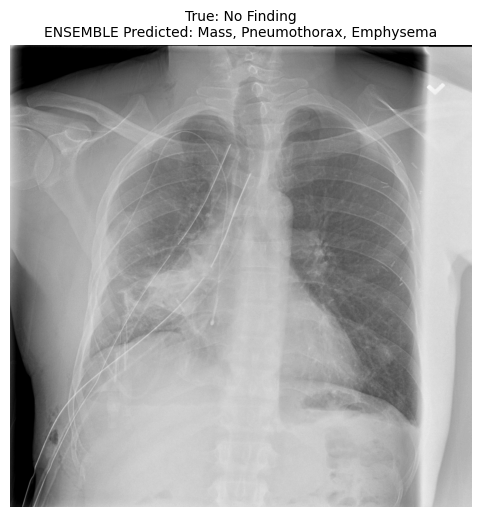


Processing image: 00008232_000.png
True Findings:    No Finding
ENSEMBLE Predicted: Atelectasis, Effusion
-------------------------------------------------------------
Detailed Ensemble Probabilities & Predictions:
  - Atelectasis         : Probability=0.5486, Threshold=0.54 >> POSITIVE <<
  - Cardiomegaly        : Probability=0.1232, Threshold=0.61 
  - Effusion            : Probability=0.6905, Threshold=0.54 >> POSITIVE <<
  - Infiltration        : Probability=0.3413, Threshold=0.46 
  - Mass                : Probability=0.4374, Threshold=0.60 
  - Nodule              : Probability=0.1677, Threshold=0.54 
  - Pneumonia           : Probability=0.2528, Threshold=0.52 
  - Pneumothorax        : Probability=0.3980, Threshold=0.59 
  - Consolidation       : Probability=0.5357, Threshold=0.54 
  - Edema               : Probability=0.1328, Threshold=0.60 
  - Emphysema           : Probability=0.1631, Threshold=0.61 
  - Fibrosis            : Probability=0.1090, Threshold=0.57 
  - Pleural_

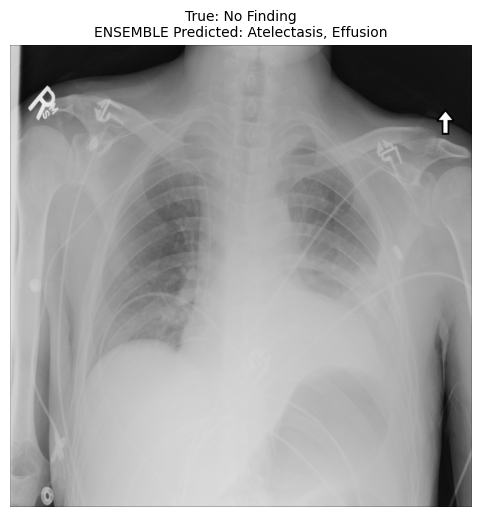

In [15]:
# Cell J: Ensemble Inference and Visualization on Sample Images

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# --- Prerequisite Checks ---
# This cell assumes the following are ready from previous cells:
# - 'my_model': Your trained champion model.
# - 'arnoweng_model': The loaded Arnoweng model.
# - 'val_df': The validation DataFrame.
# - 'val_transform': The Albumentations transform for your model.
# - 'arnoweng_transform': The torchvision transform for the Arnoweng model.
# - 'optimal_thresholds_ensemble': The dictionary of tuned thresholds for the ENSEMBLE.
# - 'disease_labels': The list of 14 class names.
# - 'device': The primary CUDA device.

if 'my_model' not in locals() or 'arnoweng_model' not in locals() or 'optimal_thresholds_ensemble' not in locals():
    print("❌ ERROR: One or more required components are missing. Please run all previous cells, including the final bake-off.")
else:
    # --- 1. Define the ENSEMBLE Inference Function ---
    def predict_with_ensemble(image_path, model1, transform1, model2, transform2, thresholds, class_names, device):
        model1.eval()
        model2.eval()
        try:
            # --- Get Prediction from Your Model ---
            image1_np = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image1_np is None: raise IOError("cv2.imread failed")
            augmented1 = transform1(image=image1_np)
            tensor1 = augmented1['image'].unsqueeze(0).to(device)
            with torch.no_grad():
                logits1 = model1(tensor1)
                probs1 = torch.sigmoid(logits1).cpu().numpy().flatten()

            # --- Get Prediction from Arnoweng Model ---
            image2_pil = Image.open(image_path).convert("RGB")
            tensor2 = transform2(image2_pil).unsqueeze(0).to(device)
            with torch.no_grad():
                # Arnoweng model outputs probabilities directly
                probs2 = model2(tensor2).cpu().numpy().flatten()
            
            # --- Average the probabilities ---
            ensemble_probs = (probs1 + probs2) / 2.0
            
            # Generate final predictions using the ensemble's optimal thresholds
            predictions = {
                class_names[i]: {
                    "probability": float(ensemble_probs[i]),
                    "prediction": 1 if ensemble_probs[i] >= thresholds.get(class_names[i], 0.5) else 0
                } for i in range(len(class_names))
            }
            return predictions

        except Exception as e:
            print(f"An error occurred during ensemble prediction for {image_path}: {e}")
            return None
    print("✅ Ensemble inference function 'predict_with_ensemble' defined.")

    # --- 2. Test the Function on NEW Random Sample Images from the Validation Set ---
    if 'val_df' in locals() and not val_df.empty:
        num_samples_to_test = 5
        sample_images_df = val_df.sample(n=num_samples_to_test)
        print(f"\n--- Testing ENSEMBLE inference on {num_samples_to_test} NEW random validation images ---")

        for index, row in sample_images_df.iterrows():
            image_path = row['full_path']
            true_labels = {label: int(row[label]) for label in disease_labels}
            true_findings = [label for label, present in true_labels.items() if present == 1]
            if not true_findings: true_findings = ["No Finding"]

            print(f"\n=============================================================")
            print(f"Processing image: {os.path.basename(image_path)}")
            print(f"True Findings:    {', '.join(true_findings)}")
            
            # Call the new ensemble prediction function
            ensemble_predictions = predict_with_ensemble(
                image_path,
                my_model, val_transform,
                arnoweng_model, arnoweng_transform,
                optimal_thresholds_ensemble, # Use the ensemble's thresholds
                disease_labels,
                device
            )
            
            if ensemble_predictions:
                predicted_findings = [label for label, data in ensemble_predictions.items() if data['prediction'] == 1]
                if not predicted_findings: predicted_findings = ["No Finding"]

                print(f"ENSEMBLE Predicted: {', '.join(predicted_findings)}")
                print("-------------------------------------------------------------")
                print("Detailed Ensemble Probabilities & Predictions:")
                for disease, data in ensemble_predictions.items():
                    pred_marker = ">> POSITIVE <<" if data['prediction'] == 1 else ""
                    print(f"  - {disease:<20}: Probability={data['probability']:.4f}, Threshold={optimal_thresholds_ensemble.get(disease, 0.5):.2f} {pred_marker}")
                
                plt.figure(figsize=(6, 6))
                display_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                plt.imshow(display_image, cmap='gray')
                plt.title(f"True: {', '.join(true_findings)}\nENSEMBLE Predicted: {', '.join(predicted_findings)}", fontsize=10)
                plt.axis('off')
                plt.show()
    else:
        print("\nSkipping inference test: 'val_df' not found.")

In [16]:
# Cell K: Save Final Ensemble Results

import json
import os
import pandas as pd

# --- Prerequisite Checks ---
# This cell assumes the following are ready from Cell I (the "Bake-Off" cell):
# - 'ensemble_pred_probs': The averaged probability predictions.
# - 'val_true_labels': The ground truth labels.
# - 'optimal_thresholds_ensemble': The dictionary of tuned thresholds for the ensemble.
# - 'disease_labels': The list of 14 class names.

if 'optimal_thresholds_ensemble' not in locals():
    print("❌ ERROR: 'optimal_thresholds_ensemble' not found. Please run the Bake-Off cell (Cell I) first.")
else:
    print("--- Saving Final Ensemble Artifacts ---")
    
    # --- 1. Configuration ---
    RESULTS_PREFIX = 'ensemble_final' # A clear prefix for our champion ensemble
    KAGGLE_WORKING_DIR = '/kaggle/working/'
    
    THRESHOLDS_FILENAME = f'optimal_thresholds_{RESULTS_PREFIX}.json'
    REPORT_FILENAME = f'classification_report_{RESULTS_PREFIX}.txt'
    THRESHOLDS_CSV_FILENAME = f'optimal_thresholds_{RESULTS_PREFIX}.csv'

    # --- 2. Save the Optimal Thresholds (JSON and CSV) ---
    # JSON for loading in code
    thresholds_path = os.path.join(KAGGLE_WORKING_DIR, THRESHOLDS_FILENAME)
    try:
        with open(thresholds_path, 'w') as f:
            json.dump(optimal_thresholds_ensemble, f, indent=4)
        print(f"✅ Ensemble optimal thresholds saved to: '{thresholds_path}'")
    except Exception as e:
        print(f"Error saving ensemble thresholds to JSON: {e}")
        
    # CSV for easy viewing
    try:
        thresholds_df = pd.DataFrame(list(optimal_thresholds_ensemble.items()), columns=['Disease', 'Optimal_Threshold'])
        thresholds_csv_path = os.path.join(KAGGLE_WORKING_DIR, THRESHOLDS_CSV_FILENAME)
        thresholds_df.to_csv(thresholds_csv_path, index=False)
        print(f"✅ Ensemble optimal thresholds also saved to CSV: '{thresholds_csv_path}'")
    except Exception as e:
        print(f"Error saving ensemble thresholds to CSV: {e}")

    # --- 3. Generate and Save the Classification Report ---
    report_path = os.path.join(KAGGLE_WORKING_DIR, REPORT_FILENAME)
    try:
        # Re-generate the report to ensure it's saved
        ensemble_pred_binary = np.zeros_like(ensemble_pred_probs)
        for i, disease_name in enumerate(disease_labels):
            ensemble_pred_binary[:, i] = (ensemble_pred_probs[:, i] >= optimal_thresholds_ensemble[disease_name]).astype(int)
        
        report = classification_report(
            val_true_labels,
            ensemble_pred_binary,
            target_names=disease_labels,
            zero_division=0
        )
        
        # Get the final Macro AUC and F1 for the report context
        final_ensemble_auc = roc_auc_score(val_true_labels, ensemble_pred_probs, average='macro')
        final_ensemble_f1 = f1_score(val_true_labels, ensemble_pred_binary, average='macro', zero_division=0)

        with open(report_path, 'w') as f:
            f.write(f"--- Final Classification Report for ENSEMBLE Model ---\n\n")
            f.write("This model is an average of 'my_champion_model' and 'arnoweng_model'.\n")
            f.write(f"Final Validation Macro AUC: {final_ensemble_auc:.4f}\n")
            f.write(f"Final Validation Macro F1-Score (with optimal thresholds): {final_ensemble_f1:.4f}\n\n")
            f.write(report)
        print(f"✅ Final ensemble classification report saved to: '{report_path}'")
    except Exception as e:
        print(f"Error saving ensemble report to text file: {e}")

    # --- 4. Reminder to Persist Files ---
    print("\n--- IMPORTANT KAGGLE NOTE ---")
    print("To save these files permanently, you must 'Commit' your notebook using 'Quick Save'.")

--- Saving Final Ensemble Artifacts ---
✅ Ensemble optimal thresholds saved to: '/kaggle/working/optimal_thresholds_ensemble_final.json'
✅ Ensemble optimal thresholds also saved to CSV: '/kaggle/working/optimal_thresholds_ensemble_final.csv'
✅ Final ensemble classification report saved to: '/kaggle/working/classification_report_ensemble_final.txt'

--- IMPORTANT KAGGLE NOTE ---
To save these files permanently, you must 'Commit' your notebook using 'Quick Save'.


In [19]:
# Cell K: Save All Final Ensemble Results

import json
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, classification_report # Ensure these are imported

# --- Prerequisite Checks ---
if 'ensemble_pred_probs' not in locals() or 'optimal_thresholds_ensemble' not in locals():
    print("❌ ERROR: Required variables are missing. Please run the Bake-Off cell (Cell I) first.")
else:
    print("--- Saving All Final Ensemble Artifacts ---")
    
    # --- 1. Configuration ---
    RESULTS_PREFIX = 'ensemble_final_v1' # Use a clear version number
    KAGGLE_WORKING_DIR = '/kaggle/working/'
    
    THRESHOLDS_FILENAME = f'optimal_thresholds_{RESULTS_PREFIX}.json'
    REPORT_FILENAME = f'classification_report_{RESULTS_PREFIX}.txt'
    METRICS_FILENAME = f'final_metrics_{RESULTS_PREFIX}.json' # New file for all scores

    # --- 2. Re-calculate Final Metrics to ensure they are all available ---
    # This is a quick step and guarantees we have all the numbers to save.
    
    # Calculate Macro AUC and Per-Class AUCs
    macro_auc = roc_auc_score(val_true_labels, ensemble_pred_probs, average='macro')
    per_class_auc_scores = roc_auc_score(val_true_labels, ensemble_pred_probs, average=None)
    per_class_auc_dict = {disease: score for disease, score in zip(disease_labels, per_class_auc_scores)}
    
    # Calculate Binary Predictions and F1 Scores
    ensemble_pred_binary = np.zeros_like(ensemble_pred_probs)
    for i, disease_name in enumerate(disease_labels):
        ensemble_pred_binary[:, i] = (ensemble_pred_probs[:, i] >= optimal_thresholds_ensemble[disease_name]).astype(int)
    
    macro_f1 = f1_score(val_true_labels, ensemble_pred_binary, average='macro', zero_division=0)
    
    # Generate the text report
    report = classification_report(val_true_labels, ensemble_pred_binary, target_names=disease_labels, zero_division=0)
    
    # --- 3. Create a comprehensive dictionary of all metrics ---
    final_metrics = {
        'macro_averaged_auc': macro_auc,
        'macro_averaged_f1_score': macro_f1,
        'per_class_auc': per_class_auc_dict,
        'optimal_thresholds': optimal_thresholds_ensemble
    }
    
    # --- 4. Save All Artifacts ---

    # Save the comprehensive metrics dictionary to a JSON file
    metrics_path = os.path.join(KAGGLE_WORKING_DIR, METRICS_FILENAME)
    try:
        with open(metrics_path, 'w') as f:
            json.dump(final_metrics, f, indent=4)
        print(f"✅ All final metrics saved to: '{metrics_path}'")
    except Exception as e:
        print(f"Error saving final metrics to JSON: {e}")
        
    # Save the human-readable Classification Report to a text file
    report_path = os.path.join(KAGGLE_WORKING_DIR, REPORT_FILENAME)
    try:
        with open(report_path, 'w') as f:
            f.write(f"--- Final Classification Report for ENSEMBLE Model ---\n\n")
            f.write(f"Macro AUC: {macro_auc:.4f}\n")
            f.write(f"Macro F1-Score (tuned): {macro_f1:.4f}\n\n")
            f.write(report)
        print(f"✅ Final classification report saved to: '{report_path}'")
    except Exception as e:
        print(f"Error saving report to text file: {e}")

    # --- 5. Reminder to Persist Files ---
    print("\n--- IMPORTANT KAGGLE NOTE ---")
    print("To save these files permanently, you must 'Commit' your notebook using 'Quick Save'.")

--- Saving All Final Ensemble Artifacts ---
✅ All final metrics saved to: '/kaggle/working/final_metrics_ensemble_final_v1.json'
✅ Final classification report saved to: '/kaggle/working/classification_report_ensemble_final_v1.txt'

--- IMPORTANT KAGGLE NOTE ---
To save these files permanently, you must 'Commit' your notebook using 'Quick Save'.


--- Setting up for Grad-CAM Visualization ---
✅ Target layers for both models set.
✅ Grad-CAM objects created for both models.

Generating Grad-CAM for image: 00014601_000.png
True Findings: Mass


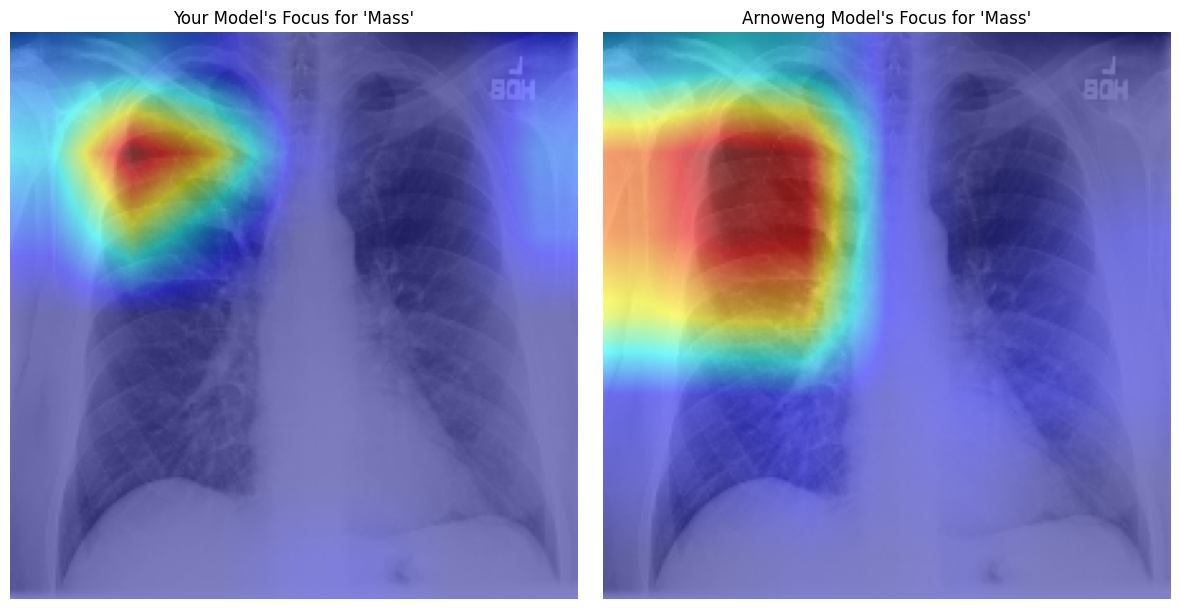

In [18]:
# Cell L: Grad-CAM for Both Models on a Single Image

# --- 1. Install the grad-cam library (if not already installed in the session) ---
!pip install -q grad-cam

import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Prerequisite Checks ---
if 'my_model' not in locals() or 'arnoweng_model' not in locals() or 'val_df' not in locals():
    print("❌ ERROR: Required models or validation dataframe are missing.")
else:
    print("--- Setting up for Grad-CAM Visualization ---")
    
    # --- 2. Define Target Layers for Both Models ---
    try:
        my_model_target_layers = [my_model.backbone.features.denseblock4]
        arnoweng_model_target_layers = [arnoweng_model.densenet121.features.denseblock4]
        print("✅ Target layers for both models set.")
    except AttributeError as e:
        print(f"❌ ERROR: Could not find a target layer. Error: {e}")
        my_model_target_layers = None
        arnoweng_model_target_layers = None

    # --- 3. Create Grad-CAM instances for Both Models ---
    if my_model_target_layers and arnoweng_model_target_layers:
        cam_my_model = GradCAM(model=my_model, target_layers=my_model_target_layers)
        cam_arnoweng = GradCAM(model=arnoweng_model, target_layers=arnoweng_model_target_layers)
        print("✅ Grad-CAM objects created for both models.")
    else:
        cam_my_model, cam_arnoweng = None, None

    # --- 4. Define a helper function to generate a heatmap ---
    def generate_heatmap(cam_instance, transform_instance, image_path, target_class_index, device):
        # Read and process the image based on the model's specific pipeline
        if isinstance(transform_instance, A.Compose): # Your model's pipeline
            img_np = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img_np is None: return None, None
            augmented = transform_instance(image=img_np)
            tensor_input = augmented['image']
            if tensor_input.ndim == 2: tensor_input = tensor_input.unsqueeze(0)
        else: # Arnoweng model's pipeline
            img_pil = Image.open(image_path).convert("RGB")
            tensor_input = transform_instance(img_pil)

        # Prepare visualization image (always the same)
        vis_img_np = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        vis_image = cv2.resize(vis_img_np, (224, 224))
        vis_image = np.float32(vis_image) / 255
        vis_image = np.stack([vis_image]*3, axis=-1)
        
        # Generate CAM
        targets = [ClassifierOutputTarget(target_class_index)]
        # Add batch dimension
        input_tensor_batch = tensor_input.unsqueeze(0).to(device)
        # Handle 1-channel vs 3-channel for arnoweng model
        if cam_instance.model is arnoweng_model and input_tensor_batch.shape[1] == 1:
             input_tensor_batch = input_tensor_batch.repeat(1, 3, 1, 1)

        grayscale_cam = cam_instance(input_tensor=input_tensor_batch, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(vis_image, grayscale_cam, use_rgb=True)
        return visualization

    # --- 5. Run Demonstration ---
    if cam_my_model and cam_arnoweng:
        # Pick a random image that has at least one finding
        sample_df = val_df[val_df[disease_labels].sum(axis=1) > 0].sample(1)
        image_path = sample_df.iloc[0]['full_path']
        true_findings = [label for label in disease_labels if sample_df.iloc[0][label] == 1]

        print(f"\n============================================================")
        print(f"Generating Grad-CAM for image: {os.path.basename(image_path)}")
        print(f"True Findings: {', '.join(true_findings)}")

        # Create a subplot for each model
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Generate heatmap from YOUR model for the FIRST true finding
        vis_my_model = generate_heatmap(cam_my_model, val_transform, image_path, disease_labels.index(true_findings[0]), device)
        if vis_my_model is not None:
            axes[0].imshow(vis_my_model)
            axes[0].set_title(f"Your Model's Focus for '{true_findings[0]}'")
            axes[0].axis('off')

        # Generate heatmap from ARNOWENG'S model for the FIRST true finding
        vis_arnoweng = generate_heatmap(cam_arnoweng, arnoweng_transform, image_path, disease_labels.index(true_findings[0]), device_arnoweng)
        if vis_arnoweng is not None:
            axes[1].imshow(vis_arnoweng)
            axes[1].set_title(f"Arnoweng Model's Focus for '{true_findings[0]}'")
            axes[1].axis('off')

        plt.tight_layout()
        plt.show()

In [20]:
# Cell M: Final Ensemble Performance Summary

import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# --- Prerequisite Checks ---
# This cell assumes the following are ready from the previous "Bake-Off" cell (Cell I):
# - 'ensemble_pred_probs': The averaged probability predictions from the ensemble.
# - 'val_true_labels': The ground truth labels.
# - 'optimal_thresholds_ensemble': The dictionary of tuned thresholds for the ensemble.
# - 'disease_labels': The list of 14 class names.

if 'ensemble_pred_probs' not in locals() or 'optimal_thresholds_ensemble' not in locals():
    print("❌ ERROR: Required variables are missing. Please run the full Bake-Off cell (Cell I) first.")
else:
    # --- 1. Apply Optimal Thresholds to get final binary predictions ---
    ensemble_pred_binary = np.zeros_like(ensemble_pred_probs)
    for i, disease_name in enumerate(disease_labels):
        ensemble_pred_binary[:, i] = (ensemble_pred_probs[:, i] >= optimal_thresholds_ensemble[disease_name]).astype(int)

    # --- 2. Calculate the Multilabel Confusion Matrix ---
    mcm = multilabel_confusion_matrix(val_true_labels, ensemble_pred_binary)
    
    # --- 3. Generate the Detailed Text Report ---
    print("\n" + "="*65)
    print("--- DETAILED PERFORMANCE REPORT FOR THE FINAL ENSEMBLE MODEL ---")
    print("="*65)
    print("Metrics are calculated on the validation set using optimal per-class thresholds.\n")
    
    # Initialize lists to store metrics for calculating averages
    all_precisions = []
    all_recalls = []
    all_f1s = []
    all_accuracies = []

    for i, label in enumerate(disease_labels):
        tn, fp, fn, tp = mcm[i].ravel()
        
        # Calculate key metrics from the matrix values
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Append to lists for averaging
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
        all_accuracies.append(accuracy)
        
        print(f"--- Disease: {label} ---")
        print(f"  - True Positives (TP):  {tp:5d}  (Correctly predicted as PRESENT)")
        print(f"  - False Positives (FP): {fp:5d}  (Incorrectly predicted as PRESENT - Error Type I)")
        print(f"  - True Negatives (TN):  {tn:5d}  (Correctly predicted as ABSENT)")
        print(f"  - False Negatives (FN): {fn:5d}  (Incorrectly predicted as ABSENT - MISSED CASES - Error Type II)")
        print("-" * 40)
        print(f"  - Accuracy:    {accuracy:.4f} (Overall correctness for this class)")
        print(f"  - Precision:   {precision:.4f} (How many 'present' predictions were correct?)")
        print(f"  - Recall:      {recall:.4f} (How many of the actual 'present' cases were found?)")
        print(f"  - F1-Score:    {f1:.4f} (Harmonic mean of Precision and Recall)")
        print("-" * 40 + "\n")
        
    # --- 4. Print the Final Averages ---
    print("\n" + "="*65)
    print("--- OVERALL AVERAGED METRICS (MACRO AVG) ---")
    print("="*65)
    print(f"  - Average Accuracy:    {np.mean(all_accuracies):.4f}")
    print(f"  - Average Precision:   {np.mean(all_precisions):.4f}")
    print(f"  - Average Recall:      {np.mean(all_recalls):.4f}")
    print(f"  - Average F1-Score:    {np.mean(all_f1s):.4f} (This matches the 'macro avg' from the classification report)")
    print("="*65)


--- DETAILED PERFORMANCE REPORT FOR THE FINAL ENSEMBLE MODEL ---
Metrics are calculated on the validation set using optimal per-class thresholds.

--- Disease: Atelectasis ---
  - True Positives (TP):   1252  (Correctly predicted as PRESENT)
  - False Positives (FP):  2120  (Incorrectly predicted as PRESENT - Error Type I)
  - True Negatives (TN):  17967  (Correctly predicted as ABSENT)
  - False Negatives (FN):   955  (Incorrectly predicted as ABSENT - MISSED CASES - Error Type II)
----------------------------------------
  - Accuracy:    0.8621 (Overall correctness for this class)
  - Precision:   0.3713 (How many 'present' predictions were correct?)
  - Recall:      0.5673 (How many of the actual 'present' cases were found?)
  - F1-Score:    0.4488 (Harmonic mean of Precision and Recall)
----------------------------------------

--- Disease: Cardiomegaly ---
  - True Positives (TP):    360  (Correctly predicted as PRESENT)
  - False Positives (FP):   600  (Incorrectly predicted as 